# Demo with rebayes mini

In [1]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
from rebayes_mini.methods import extended_kalman_filter as ekf
from rebayes_mini.methods import replay_sgd as rsgd

In [136]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
def f(x):
    return x - 10 * jnp.cos(x) * jnp.sin(x) + x ** 3


def sample_observations(key, f, n_obs, xmin, xmax, x_noise=0.1, y_noise=3.0):
    key_x, key_y, key_shuffle = jax.random.split(key, 3)
    x_noise = jax.random.normal(key_x, (n_obs,)) * x_noise
    y_noise = jax.random.normal(key_y, (n_obs,)) * y_noise
    x = jnp.linspace(xmin, xmax, n_obs) + x_noise
    y = f(x) + y_noise
    X = jnp.c_[x, y]

    shuffled_ixs = jax.random.permutation(key_shuffle, jnp.arange(n_obs))
    x, y = jnp.array(X[shuffled_ixs, :].T)
    return x, y

In [172]:
key = jax.random.PRNGKey(314)
key_train, key_sample_obs = jax.random.split(key)

n_obs = 200
xmin, xmax = -3, 3
sigma_y = 3.0
x, y = sample_observations(key_sample_obs, f, n_obs, xmin, xmax, x_noise=0, y_noise=sigma_y)
xtest = jnp.linspace(x.min(), x.max(), n_obs)

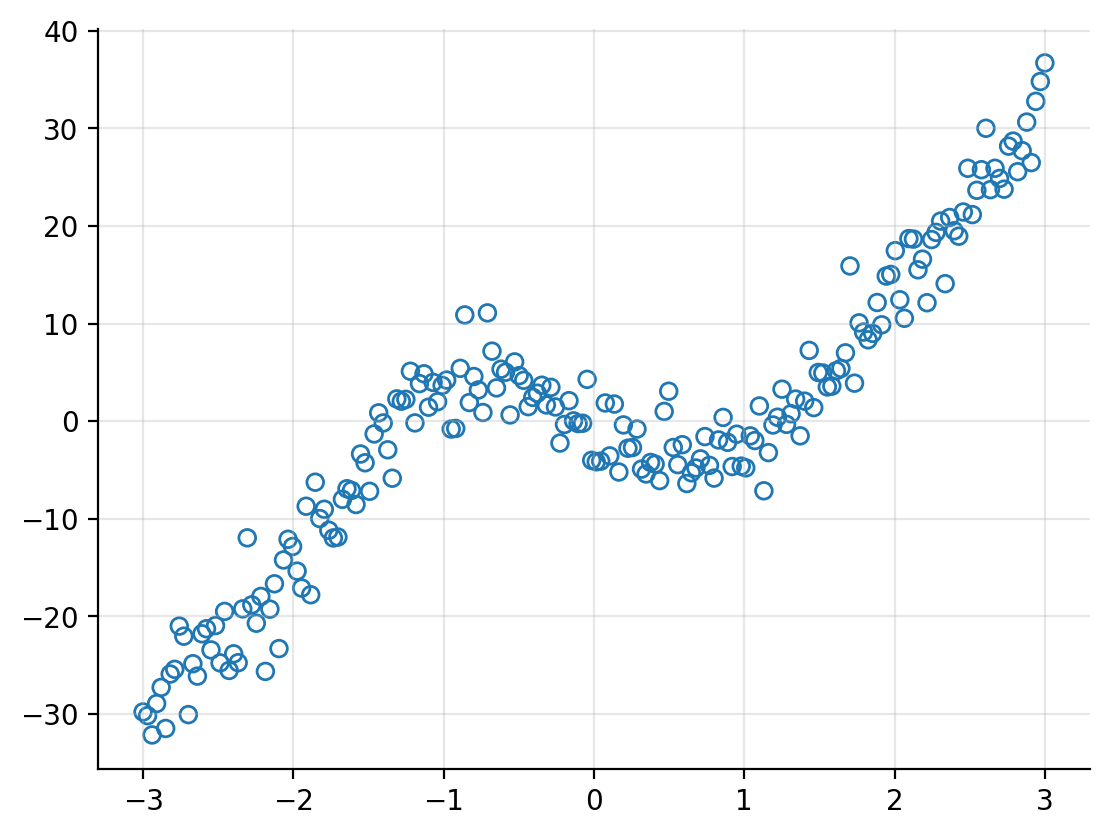

In [173]:
plt.scatter(x, y, edgecolors="tab:blue", color="none")
plt.grid(alpha=0.3)

In [254]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(6)(x)
        x = nn.elu(x)
        x = nn.Dense(6)(x)
        x = nn.elu(x)
        x = nn.Dense(6)(x)
        x = nn.elu(x)
        x = nn.Dense(1)(x)
        return x

In [255]:
model = MLP()
params_init = model.init(key_train, x[:, None])

def lossfn(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    return jnp.sum(counter * (y - yhat) ** 2) / counter.sum()

In [256]:
tx = optax.adam(1e-2)

In [261]:
n_inner = 1
agent_sgd = rsgd.FifoSGD(
    model.apply, lossfn, tx, buffer_size=1, dim_features=1, dim_output=1,
    n_inner=n_inner
)
bel_init = agent_sgd.init_bel(params_init)
bel_sgd, hist_bel_sgd = agent_sgd.scan(bel_init, y, x[:, None])
yhat_sgd = model.apply(bel_sgd.params, xtest[:, None]).ravel()

In [262]:
agent_ekf = ekf.GaussianFilter(
    model.apply, dynamics_covariance=0.0, variance=1.0
    
)

bel_init = agent_ekf.init_bel(params_init, cov=0.01)
bel_ekf, hist_bel_ekf = agent_ekf.scan(bel_init, y, x[:, None])

yhat_ekf = agent_ekf.link_fn(bel_ekf.mean, xtest[:, None]).ravel()

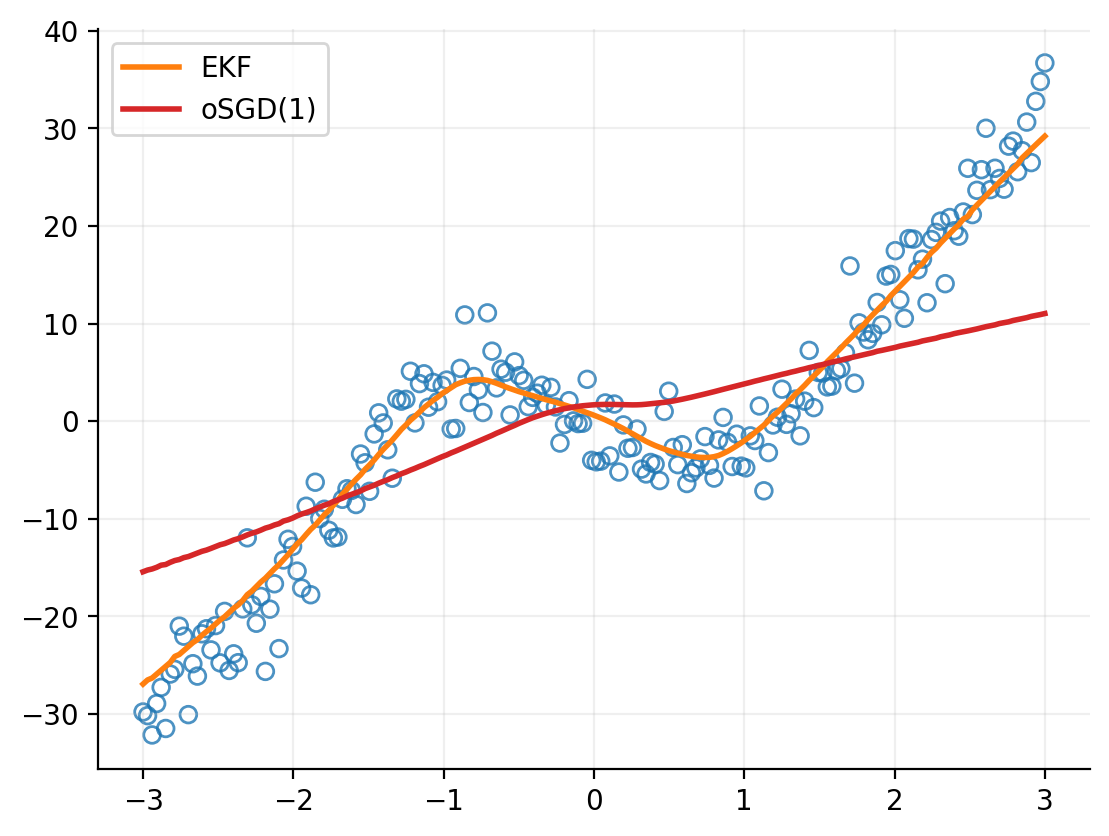

In [263]:
plt.scatter(x, y, edgecolors="tab:blue", c="none", alpha=0.8)
plt.plot(xtest, yhat_ekf, c="tab:orange", linewidth=2, label="EKF")
plt.plot(xtest, yhat_sgd, c="tab:red", linewidth=2, label=f"oSGD({n_inner})")
plt.legend()
plt.grid(alpha=0.2)

### Animate

MovieWriter ffmpeg unavailable; using Pillow instead.


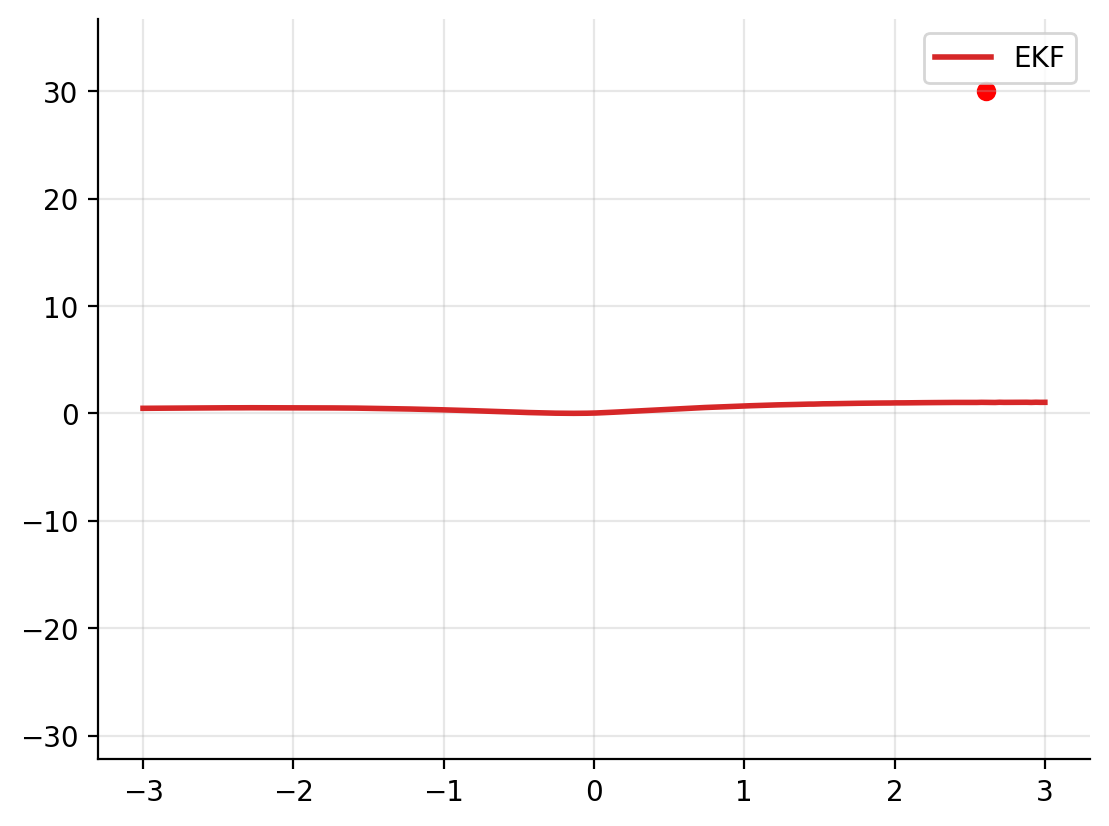

In [265]:
fig, ax = plt.subplots()


def animate(t):
    ax.cla()
    params_t = jax.tree_map(lambda x: x[t], hist_bel_ekf)
    yhat_ekf = agent_ekf.link_fn(params_t.mean, xtest[:, None]).ravel()
    
    # params_t = jax.tree_map(lambda x: x[t], hist_bel_sgd)
    # yhat_sgd = agent_sgd.apply_fn(params_t, xtest[:, None]).ravel()


    plt.scatter(x[:t], y[:t], edgecolors="tab:blue", c="none", alpha=0.8)
    plt.scatter(x[t], y[t], c="red")
    # plt.plot(xtest, yhat_sgd, c="tab:orange", linewidth=2, label=f"oSGD({n_inner})")
    plt.plot(xtest, yhat_ekf, c="tab:red", linewidth=2, label=f"EKF")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.ylim(y.min(), y.max())

animation = FuncAnimation(fig, animate, frames=n_obs)
# animation.save(f"ekf-osgd{n_inner}.gif", fps=15)
animation.save(f"ekf.gif", fps=15)